In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.fftpack as spfft
from numpy import linalg as LA
import sys, os
from PIL import Image
import cvxpy as cvx
from numpy import linalg as LA


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# 1. Three algorithms

In [19]:
####  OMP  ####
def omp(X, y, nonneg=True, nsoltncoef=None, maxit=500, tol=1e-4):

    # by default set max number of soltncoef to half of total possible
    if nsoltncoef is None:
        nsoltncoef = int(X.shape[1]/2)
    
    ############# initialize things # algorithm step 0(Input) ############
    X_transpose = X.T                       
    nonzerosoltncoef = []
    soltncoef = np.zeros(X.shape[1], dtype=float) 
    residual = y                           
    ypred = np.zeros(y.shape, dtype=float)
    err = np.zeros(maxit, dtype=float)      
   
    ############ main iteration # algorithm step 1 #############
    for it in range(maxit):
        # compute residual covariance vector and check threshold
        rcov = np.dot(X_transpose, residual)
        # algorithm step 3 choose i to maximize step2
        if nonneg:
            i = np.argmax(rcov)
            rc = rcov[i]
        else:
            i = np.argmax(np.abs(rcov))
            rc = np.abs(rcov[i])
        
        # algorithm step 2 (nonzero components)
        if i not in nonzerosoltncoef:
            nonzerosoltncoef.append(i)

        # algorithm step 2( least squares)
        soltncoefi, _, _, _ = np.linalg.lstsq(X[:, nonzerosoltncoef], y)
        soltncoef[nonzerosoltncoef] = soltncoefi   # update solution
        
        ######## algorithm step 3 ########
        residual = y - np.dot(X[:,nonzerosoltncoef], soltncoefi)
        ypred = y - residual
        
        ######### check stopping criteria # algorithm step 4 ########
        err[it] =  np.linalg.norm(residual)**2 
        if err[it] < tol:  # converged
            print('\nConverged at',it)
            break
        if len(nonzerosoltncoef) >= nsoltncoef:   # hit max soltncoefficients
            print('\nFound solution with max number of soltncoefficients.')
            break
        if it == maxit-1:  # max iterations
            print('\nreached the max number of iterations.')
    return soltncoef, nonzerosoltncoef, err[:(it+1)], residual, ypred

if __name__ == '__main__':
    pass

In [20]:
#### spaRSA ####

def f(A, x, y):
    residual = A @ x - y
    return np.dot(residual, residual) / 2

def gradient(A, x, y):
    return A.T @ (A @ x - y)

def phi(A, x, y, tau, norm=1):
    return f(A, x, y) + tau * LA.norm(x, norm)

def soft(u, a):
    # u is a vector, a is a scalar
    # element-wise operations
    return np.sign(u) * np.maximum(np.abs(u) - a, 0)

def hard(u, a):
    # u is a vector, a is a scalar
    # element-wise operations
    return u * (np.abs(u) > a)

def solve_sub_prob(u, tau, alpha, norm=1):
    # u: vector
    # tau, alpha: scalar
    # norm: 1 or 0 (either l-1 or l-0 norm)
    # assume we do not use any other norms
    if norm == 1:
        return soft(u, tau / alpha)
    return hard(u, np.sqrt(2 * tau / alpha))

def barzilai_borwein(A, x, prev_x):
    alpha_min = 1e-10 # constant alpha min
    alpha_max = 1e10 # constant alpha max
    # A: given matrix
    # x: x_k
    # prev_x: x_(k-1)
    s = x - prev_x
    # add fl. pt. correction
    alpha = np.dot(A @ s, A @ s) / (sys.float_info.min + np.dot(s, s))
    alpha = min(alpha_max, max(alpha_min, alpha))
    return alpha

def spaRSA(A, y, tau, norm=1):
    eta = 1.5 # factor, eta > 1
    k = 0 # iter counter
    x = np.zeros(A.shape[1]) # init guess of x
    alpha = 1.0 # init alpha
    tol = 1e-4
    
    while True:
        # save current value
        prev_x = x
        prev_phi = phi(A, prev_x, y, tau, norm)
        # find the next x
        while True:
            u = prev_x - gradient(A, prev_x, y) / alpha
            x = solve_sub_prob(u, tau, alpha, norm) # update x_k
            alpha *= eta # update alpha_k
            curr_phi = phi(A, x, y, tau, norm)
            if curr_phi < prev_phi:
                break # the acceptance criterion is satisfied

        k += 1 # update counter
        alpha = barzilai_borwein(A, x, prev_x) # choose the next alpha
        if np.abs(curr_phi - prev_phi) / prev_phi < tol:
            break # stop criterion: no more relative decrease
    # end of outer loop
    yhat = A @ x
    return x, yhat

In [58]:
#### GPSR ####
def GPSR_Basic(y: np.ndarray, A: np.ndarray, tau: np.ndarray, true_x: np.ndarray = None):

    def AT_(x: np.ndarray):
        return A.T@x

    def A_(x: np.ndarray):
        return A@x

    if true_x is not None:
        compute_mse = True
    else:
        compute_mse = False
    
    # Set the defaults for the optional parameters
    stopCriterion = 3 
    tolA = 1e-8 
    tolD = 0.0001 
    debias = 0
    maxiter = 10000 
    maxiter_debias = 500 
    miniter = 5 
    miniter_debias = 0 
    init = 0
    verbose = True
    continuation = 1
    cont_steps = 5 
    firstTauFactorGiven = 0
    firstTauFactor = 0.5*np.max(np.abs(AT_(y)))

    realmin = np.finfo(float).tiny
    eps = np.finfo(float).eps
    # sufficient decrease parameter for GP line search
    mu = 0.1 
    # backtracking parameter for line search 
    lambda_backtrack = 0.5 
    
    # Set the defaults for outputs that may not be computed
    debias_start = 0 
    x_debias = [] 
    mses = []
    objective = []
    times_list = []
    lambdas = []

    
    if stopCriterion in [0, 1, 2, 3, 4]:
        print("error", "Unknown stopping criterion")

    # Precompute A.T@y since it'll be used a lot
    Aty = AT_(y)

    # Initialization
    if init == 0:   # initialize at zero, using AT to find the np.shape of x
        x = AT_(np.zeros_like(y))
    elif init == 1:   # initialize randomly, using AT to find the np.shape of x
        x = np.random.randn(np.shape(AT_(np.zeros_like(y)))[0], np.shape(AT_(np.zeros_like(y)))[1])
    else:   # initialize x0 = A.T@y
        x = Aty

    # now check if tau is an array  if it is, it has to
    # have the same np.shape as x
    if np.prod(np.shape(tau)) > 1:
        try:
            dummy = x*tau
        except:
            raise NameError('Parameter tau has wrong dimensions  it should be scalar or np.shape(x)')


    # if the true x was given, check its np.shape
    if compute_mse and (np.shape(true_x) != np.shape(x)):
        raise NameError('Initial x has incompatible np.shape')

    # if tau is scalar, we check its value  if it's large enough,
    # the optimal solution is the zero vector
    if np.prod(np.shape(tau)) == 1:
        aux = AT_(y)
        max_tau = np.max(np.abs(aux))
        if tau >= max_tau:
            x = np.zeros_like(aux)
            if debias:
                x_debias = x
            objective.append(0.5*(y.T@y))
            times_list.append(0)
            if compute_mse:
                mses.append(np.sum(np.power(x - true_x, 2)))
            return

    # initialize u and v
    u = x*(x >= 0)
    v = -x*(x < 0)

    # define the indicator vector or matrix of nonzeros in x
    nz_x = (x != 0.0)
    num_nz_x = np.sum(nz_x)

    # Compute and store initial value of the objective function
    resid =  y - A_(x)
    f = 0.5*(resid.T@resid) + np.sum(tau*u) + np.sum(tau*v)

    # auxiliary vector on ones, same np.shape as x
    onev = np.ones_like(x)

    # start the clock
    t0 = time.time()

    # store given tau, because we're going to change it in the
    # continuation procedure
    final_tau = tau

    # store given stopping criterion and threshold, because we're going
    # to change them in the continuation procedure
    final_stopCriterion = stopCriterion
    final_tolA = tolA

    # set continuation factors
    if continuation and (cont_steps > 1):
        # If tau is scalar, first check top see if the first factor is
        # too large (i.e., large enough to make the first
        # solution all zeros). If so, make it a little smaller than that.
        # Also set to that value as default
        if np.prod(np.shape(tau)) == 1:
            if (firstTauFactorGiven == 0) or (firstTauFactor*tau >= max_tau):
                firstTauFactor = 0.8*max_tau / tau
                print('parameter FirstTauFactor too large  changing')

        cont_factors = 10**np.arange(np.log10(firstTauFactor), 0, np.log10(1/firstTauFactor)/(cont_steps-1))
    else:
        cont_factors = np.array([1])
        cont_steps = 1


    iter_ = 1
    if compute_mse:
        mses.append(np.sum(np.power(x - true_x, 2)))


    # loop for continuation
    for cont_loop in range(cont_steps):

        tau = final_tau * cont_factors[cont_loop-1]

        if verbose:
            print(f'\nSetting tau = {tau}\n')

        if cont_loop == cont_steps:
            stopCriterion = final_stopCriterion
            tolA = final_tolA
        else:
            stopCriterion = 3
            tolA = 1e-3


        # Compute and store initial value of the objective function
        resid = y - A_(x)
        f = 0.5*(resid.T@resid) + np.sum(tau*u) + np.sum(tau*v)

        objective.append(f)
        times_list.append(time.time() - t0)

        # Compute the useful quantity resid_base
        resid_base = y - resid

        # control variable for the outer loop and iteration counter
        # cont_outer = (np.linalg.norm(projected_gradient) > 1.e-5)

        keep_going = 1

        if verbose:
            print('\nInitial obj=%10.6e, nonzeros=%7d\n', f, num_nz_x)

        while keep_going:
            x_previous = x

            # compute gradient
            temp = AT_(resid_base)
            term  =  temp - Aty
            gradu =  term + tau
            gradv = -term + tau

            # set search direction
            # du = -gradu  dv = -gradv  dx = du-dv
            dx = gradv-gradu
            old_u = u
            old_v = v

            # calculate useful matrix-vector product involving dx
            auv = A_(dx)
            dGd = auv.T@auv
            
            # calculate unconstrained minimizer along this direction, use this
            # as the first guess of steplength parameter lambda
            #  lambda0 = - (gradu.T@du + gradv.T@dv) / dGd
            
            # use instead a first guess based on the "conditional" direction
            condgradu = ((old_u > 0) + (gradu < 0)) * gradu
            condgradv = ((old_v > 0) + (gradv < 0)) * gradv
            auv_cond = A_(condgradu-condgradv)
            dGd_cond = auv_cond.T@auv_cond
            lambda0 = (gradu.T@condgradu + gradv.T@condgradv) / (dGd_cond + realmin)
            
            # loop to determine steplength, starting wit the initial guess above.
            lambda_ = lambda0
            while True:
                # calculate step for this lambda_ and candidate point
                du = np.maximum(u-lambda_*gradu, np.zeros(1)) - u
                u_new = u + du
                dv = np.maximum(v-lambda_*gradv, np.zeros(1)) - v
                v_new = v + dv
                dx = du-dv
                x_new = x + dx
                
                # evaluate function at the candidate point
                resid_base = A_(x_new)
                resid = y - resid_base
                f_new = 0.5*(resid.T@resid) + np.sum(tau*u_new) + np.sum(tau*v_new)
                # test sufficient decrease condition
                if f_new <= f + mu * (gradu.T@du + gradv.T@dv):
                    break
                lambda_ = lambda_ * lambda_backtrack
                print(f'\n reducing lambda_ to {lambda_}\n')

            u = u_new
            v = v_new
            prev_f = f
            f = f_new
            uvmin = np.minimum(u,v)
            u = u - uvmin
            v = v - uvmin
            x = u-v

            # calculate nonzero pattern and number of nonzeros (do this *always*)
            nz_x_prev = nz_x
            nz_x = (x!=0.0)
            num_nz_x = np.sum(nz_x)

            iter_ = iter_ + 1
            objective.append(f)
            times_list.append(time.time()-t0)
            lambdas.append(lambda_)

            if compute_mse:
                err = true_x - x
                mses.append(err.T@err)

            # print out stuff
            if verbose:
                print(f'It ={iter_}, obj={f}, lambda={lambda_}, nz={num_nz_x}')

            if stopCriterion == 0:
                # compute the stopping criterion based on the change
                # of the number of non-zero components of the estimate
                num_changes_active = (np.sum(nz_x!=nz_x_prev))
                if num_nz_x >= 1:
                    criterionActiveSet = num_changes_active
                else:
                    criterionActiveSet = tolA / 2
                keep_going = (criterionActiveSet > tolA)
                if verbose:
                    print(f'Delta n-zeros = {criterionActiveSet} (target = {tolA})\n')

            elif stopCriterion == 1:
                # compute the stopping criterion based on the relative
                # variation of the objective function.
                criterionObjective = np.abs(f-prev_f)/(prev_f)
                keep_going = (criterionObjective > tolA)
                if verbose:
                    print(f'Delta obj. = {criterionObjective} (target = {tolA})\n')

            elif stopCriterion == 2:
                # stopping criterion based on relative np.linalg.norm of step taken
                delta_x_criterion = np.linalg.norm(dx)/np.linalg.norm(x)
                keep_going = (delta_x_criterion > tolA)
                if verbose:
                    print(f'norm(delta x)/norm(x) = {delta_x_criterion} (target = {tolA})\n')

            elif stopCriterion == 3:
                # compute the "LCP" stopping criterion - again based on the previous
                # iterate. Make it "relative" to the np.linalg.norm of x.
                w = np.hstack((np.minimum(gradu, old_u), np.minimum(gradv, old_v)))
                criterionLCP = np.linalg.norm(w, np.Inf)
                criterionLCP = criterionLCP / np.max([1.0e-6, np.linalg.norm(old_u,np.Inf), np.linalg.norm(old_v,np.Inf)])
                keep_going = (criterionLCP > tolA)
                if verbose:
                    print(f'LCP = {criterionLCP} (target = {tolA})\n')

            elif stopCriterion == 4:
                # continue if not yeat reached target value tolA
                keep_going = (f > tolA)
                if verbose:
                    print(f'Objective = {f} (target = {tolA})\n')

            else:
                raise NameError('Unknwon stopping criterion')
            # end of the stopping criteria switch

            # take no less than miniter...
            if iter_<=miniter:
                keep_going = 1
            else: # and no more than maxiter iterations
                if iter_ > maxiter:
                    keep_going = 0
        # end of the main loop of the GP algorithm

    # end of the continuation loop

    # Print results
    if verbose:
        print('\nFinished the main algorithm!\nResults:\n')
        print(f'||A x - y ||_2^2 = {resid.T@resid}\n')
        print(f'||x||_1 = {np.sum(np.abs(x))}\n')
        print(f'Objective function = {f}\n')
        nz_x = (x!=0.0)
        num_nz_x = np.sum(nz_x)
        print(f'Number of non-zero components = {num_nz_x}\n')
        print(f'CPU time so far = {times_list[iter_-1]}\n')
        print('\n')


    # If the 'Debias' option is set to 1, we try to remove the bias from the l1
    # penalty, by applying CG to the least-squares problem obtained by omitting
    # the l1 term and fixing the zero coefficients at zero.

    # do this only if the reduced linear least-squares problem is
    # overdetermined, otherwise we are certainly applying CG to a problem with a
    # singular Hessian

    if (debias and (np.sum(x!=0)!=0)):
        if (num_nz_x > np.size(y)):
            if verbose:
                print('\n')
                print('Debiasing requested, but not performed\n')
                print('There are too many nonzeros in x\n\n')
                print('nonzeros in x: %8d, length of y: %8d\n',num_nz_x, np.size(y))

        elif (num_nz_x==0):
            if verbose:
                print('\n')
                print('Debiasing requested, but not performed\n')
                print('x has no nonzeros\n\n')

        else:
            if verbose:
                print('\n')
                print('Starting the debiasing phase...\n\n')

            x_debias = x
            zeroind = (x_debias!=0)
            cont_debias_cg = 1
            debias_start = iter_

            # calculate initial residual
            resid = A_(x_debias)
            resid = resid-y
            resid_prev = eps*np.ones_like(resid)

            rvec = AT_(resid)

            # mask out the zeros
            rvec = rvec * zeroind
            rTr_cg = rvec.T@rvec

            # set convergence threshold for the residual || RW x_debias - y ||_2
            tol_debias = tolD * (rvec.T@rvec)

            # initialize pvec
            pvec = -rvec

            # main loop
            while cont_debias_cg:

                # calculate A*p = Wt * Rt * R * W * pvec
                RWpvec = A_(pvec)
                Apvec = AT_(RWpvec)
                
                # mask out the zero terms
                Apvec = Apvec * zeroind
                
                # calculate alpha for CG
                alpha_cg = rTr_cg / (pvec.T@ Apvec)
                
                # take the step
                x_debias = x_debias + alpha_cg * pvec
                resid = resid + alpha_cg * RWpvec
                rvec  = rvec  + alpha_cg * Apvec
                
                rTr_cg_plus = rvec.T@rvec
                beta_cg = rTr_cg_plus / rTr_cg
                pvec = -rvec + beta_cg * pvec
                
                rTr_cg = rTr_cg_plus
                
                iter_ = iter_+1
                
                objective.append(0.5*(resid.T@resid) + np.sum(tau*np.abs(x_debias)))
                times_list.append(time.time() - t0)
                if compute_mse:
                    err = true_x - x_debias
                    mses.append((err.T@err))
                if verbose:
                    # in the debiasing CG phase, always use convergence criterion
                    # based on the residual (this is standard for CG)
                    print(' Iter = %5d, debias resid = %13.8e, convergence = %8.3e\n', iter_, resid.T@resid, rTr_cg / tol_debias)
    
                cont_debias_cg = (iter_-debias_start <= miniter_debias )or ((rTr_cg > tol_debias) and (iter_-debias_start <= maxiter_debias))

            if verbose:
                print('\nFinished the debiasing phase!\nResults:\n')
                print(f'||A x - y ||^2_2 = {resid.T@resid}\n')
                print(f'||x||_1 = {np.sum(np.abs(x))}\n')
                print(f'Objective function = {f}\n')
                nz = (x_debias != 0.0)
                print(f'Number of non-zero components = {np.sum(nz)}\n')
                print(f'CPU time so far = {times_list[iter_-1]}\n', )
                print('\n') 

    # mses = np.array(mses)
    if compute_mse:
        for k in range(len(mses)):
            mses[k] = mses[k]/np.size(true_x)
    
    return x, iter_

# 2. Singnal reconstruction

GPSR Method
Number of iterations: 30
MSE: 0.046690653192317196
Relative error: 0.21620840587284482


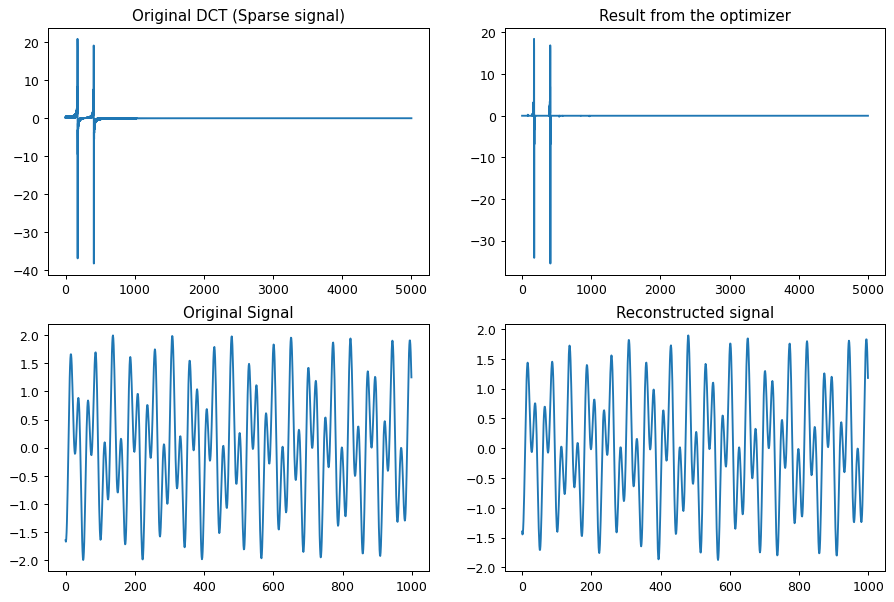

In [59]:
# Create an example for signal reconstruction
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho')

# extract small sample of signal
m = 500
ri = np.random.choice(n, m, replace=False)
ri.sort()
t2 = t[ri]
y2 = y[ri]

A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]


##### GPSR #####
print('GPSR Method')
with HiddenPrints():
    x, iterations = GPSR_Basic(y=y2, A=A, tau=np.array([0.08]))
    
print('Number of iterations:', iterations)

x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
print('MSE:', LA.norm(sig-y,2)**2/np.size(y))
print('Relative error:', LA.norm(sig-y,2)/LA.norm(y))

fig = plt.figure(figsize=(12,8), dpi= 90)

plt.subplot(221)
plt.plot(yt)
plt.title("Original DCT (Sparse signal)")
plt.subplot(222)
plt.plot(x)
plt.title("Result from the optimizer")
plt.subplot(223)
plt.plot(y[2000:3000])
plt.title("Original Signal")
plt.subplot(224)
plt.plot(sig[2000:3000])
plt.title("Reconstructed signal")
plt.show()

OMP Method


C:\Users\Chenyang Cao\AppData\Local\Temp\ipykernel_5896\4163664254.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soltncoefi, _, _, _ = np.linalg.lstsq(X[:, nonzerosoltncoef], y)



Converged at 326
Number of iterations: 26
MSE: 0.0299933980203087
Relative error: 0.17328877643276533


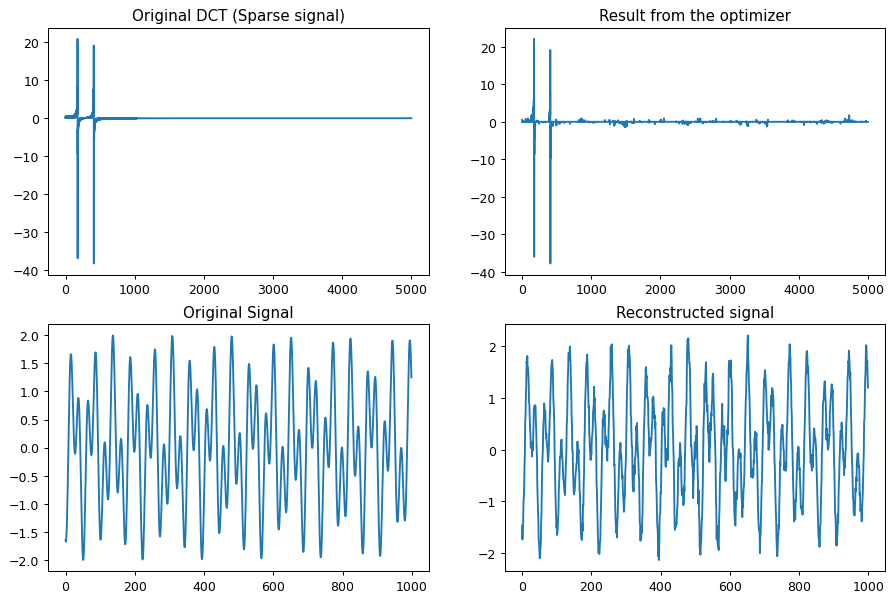

In [54]:
###### OMP Method ######
print('OMP Method')
x, _, _, _, _ = omp(A, y2,nonneg = False)
    
print('Number of iterations:', iterations)

x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
print('MSE:', LA.norm(sig-y,2)**2/np.size(y))
print('Relative error:', LA.norm(sig-y,2)/LA.norm(y))

fig = plt.figure(figsize=(12,8), dpi= 90)

plt.subplot(221)
plt.plot(yt)
plt.title("Original DCT (Sparse signal)")
plt.subplot(222)
plt.plot(x)
plt.title("Result from the optimizer")
plt.subplot(223)
plt.plot(y[2000:3000])
plt.title("Original Signal")
plt.subplot(224)
plt.plot(sig[2000:3000])
plt.title("Reconstructed signal")
plt.show()

SpaRSA Method
Number of iterations: 26
MSE: 0.047911202035917096
Relative error: 0.21901614643492578


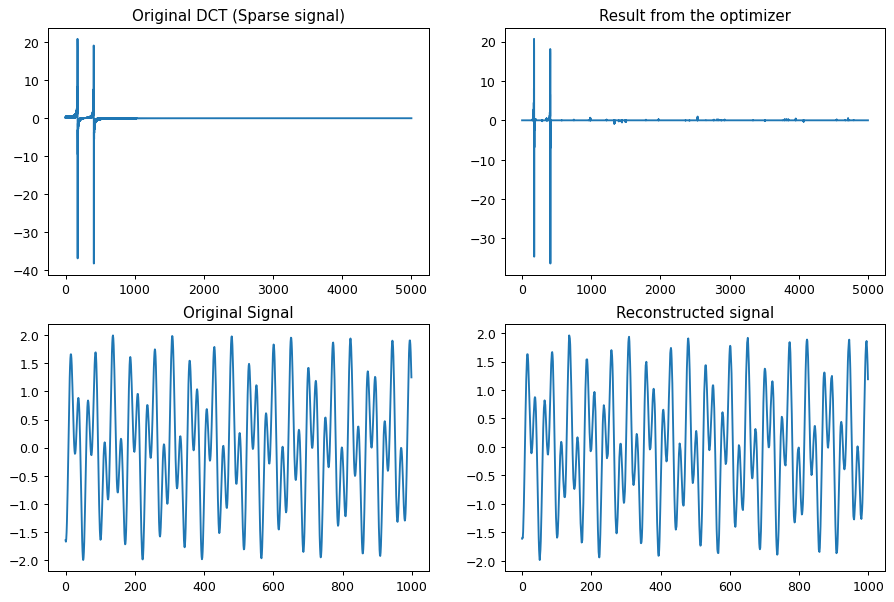

In [56]:
###### SpaRSA Method ######
print('SpaRSA Method')
x, yhat = spaRSA(A, y2, tau = np.array([0.08]))
    
print('Number of iterations:', iterations)

x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
print('MSE:', LA.norm(sig-y,2)**2/np.size(y))
print('Relative error:', LA.norm(sig-y,2)/LA.norm(y))

fig = plt.figure(figsize=(12,8), dpi= 90)

plt.subplot(221)
plt.plot(yt)
plt.title("Original DCT (Sparse signal)")
plt.subplot(222)
plt.plot(x)
plt.title("Result from the optimizer")
plt.subplot(223)
plt.plot(y[2000:3000])
plt.title("Original Signal")
plt.subplot(224)
plt.plot(sig[2000:3000])
plt.title("Reconstructed signal")
plt.show()

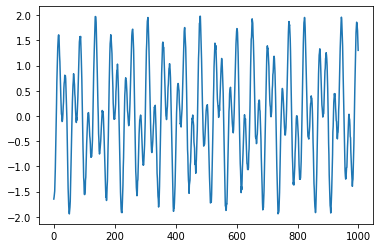

In [10]:
# # L1 optimization usng cvx
# vx = cvx.Variable(n)
# objective = cvx.Minimize(cvx.norm(vx, 1))
# constraints = [A @ vx == y2]
# prob = cvx.Problem(objective, constraints)
# result = prob.solve(verbose=True)

# sig_cvx = spfft.idct(vx.value, norm='ortho', axis=0)
# plt.plot(sig_cvx[2000:3000])

# 3. Image reconstruction

In [8]:
cameraman = Image.open('cameraman.tif')
#cameraman.show()
cameraman_array = np.array(cameraman)
cameraman_array = cameraman_array[65:235, 175:345]

lena = Image.open('lena_color_512.tif')
lena = lena.resize((200, 200))
lena_array = np.array(lena)


## 3.1 Cameraman

In [9]:
y = np.reshape(cameraman_array, np.size(cameraman_array))
n = len(y)
m = round(0.45 * n) # take 45 % of the information

ri = np.random.choice(n, m, replace=False)
ri.sort()
y2 = y[ri]

A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]
tau0 = 0.0005 * LA.norm(A.T @ y2, ord=np.inf)

The error is  0.02711105268512644


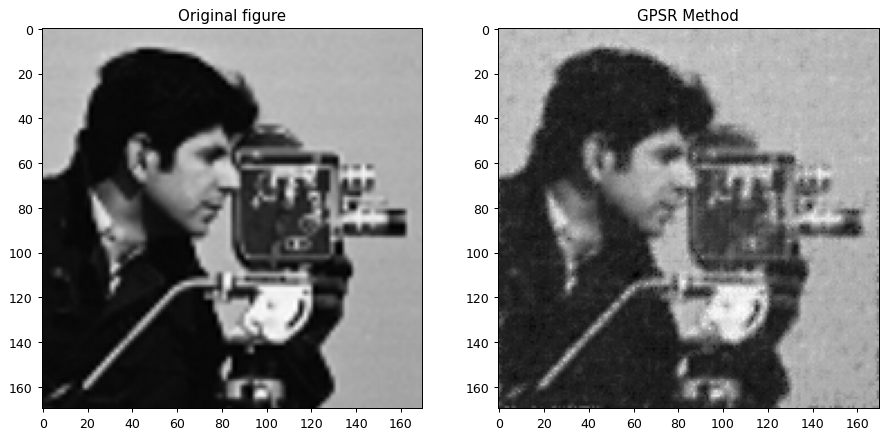

In [11]:
with HiddenPrints():
    x, _ = GPSR_Basic(y=y2, A=A, tau=0.05)
#x, _, _, _, _ = omp(A, y2,nonneg = False)
#x, yhat = spaRSA(A, y2, tau = np.array([0.08]))

x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
sig = np.reshape(sig, (np.size(cameraman_array,0), np.size(cameraman_array,1)))

fig = plt.figure(figsize=(12,8), dpi= 90)
plt.subplot(121)
plt.imshow(cameraman_array,cmap='gray')
plt.title("Original figure")
plt.subplot(122)
plt.imshow(sig,cmap='gray')
plt.title("GPSR Method")
print('The error is ', LA.norm(sig-cameraman_array,2)/LA.norm(cameraman_array))

C:\Users\Chenyang Cao\AppData\Local\Temp\ipykernel_5896\4163664254.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soltncoefi, _, _, _ = np.linalg.lstsq(X[:, nonzerosoltncoef], y)



reached the max number of iterations.
The error is  0.05007319600903936


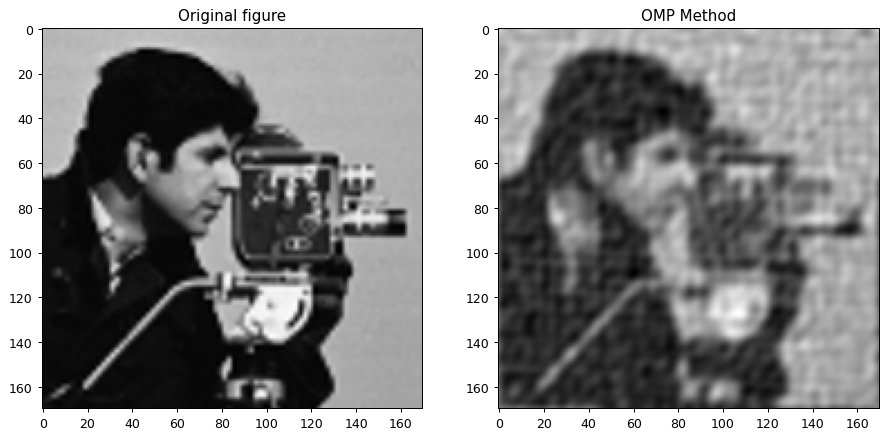

In [16]:
x, _, _, _, _ = omp(A, y2,nonneg = False)

x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
sig = np.reshape(sig, (np.size(cameraman_array,0), np.size(cameraman_array,1)))

fig = plt.figure(figsize=(12,8), dpi= 90)
plt.subplot(121)
plt.imshow(cameraman_array,cmap='gray')
plt.title("Original figure")
plt.subplot(122)
plt.imshow(sig,cmap='gray')
plt.title("OMP Method")
print('The error is ', LA.norm(sig-cameraman_array,2)/LA.norm(cameraman_array))

The error is  0.023400400586941823


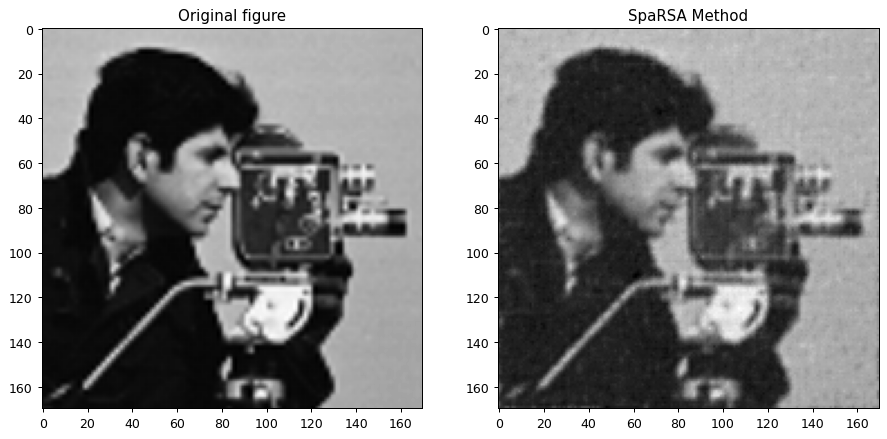

In [17]:
x, yhat = spaRSA(A, y2, tau = tau0)

x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)
sig = np.reshape(sig, (np.size(cameraman_array,0), np.size(cameraman_array,1)))

fig = plt.figure(figsize=(12,8), dpi= 90)
plt.subplot(121)
plt.imshow(cameraman_array,cmap='gray')
plt.title("Original figure")
plt.subplot(122)
plt.imshow(sig,cmap='gray')
plt.title("SpaRSA Method")
print('The error is ', LA.norm(sig-cameraman_array,2)/LA.norm(cameraman_array))

## 3.2 Lena

In [40]:
y0 = np.reshape(lena_array[:,:,0], np.size(lena_array[:,:,0]))
y1 = np.reshape(lena_array[:,:,1], np.size(lena_array[:,:,1]))
y2 = np.reshape(lena_array[:,:,2], np.size(lena_array[:,:,2]))
n = len(y0)
m = round(0.45 * n) # take 45 % of the information

ri = np.random.choice(n, m, replace=False)
ri.sort()
yy0 = y0[ri]
yy1 = y1[ri]
yy2 = y2[ri]

A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]
tau0 = 0.0005 * LA.norm(A.T @ yy0, ord=np.inf)
tau1 = 0.0005 * LA.norm(A.T @ yy1, ord=np.inf)
tau2 = 0.0005 * LA.norm(A.T @ yy2, ord=np.inf)

Text(0.5, 1.0, 'GPSR Method')

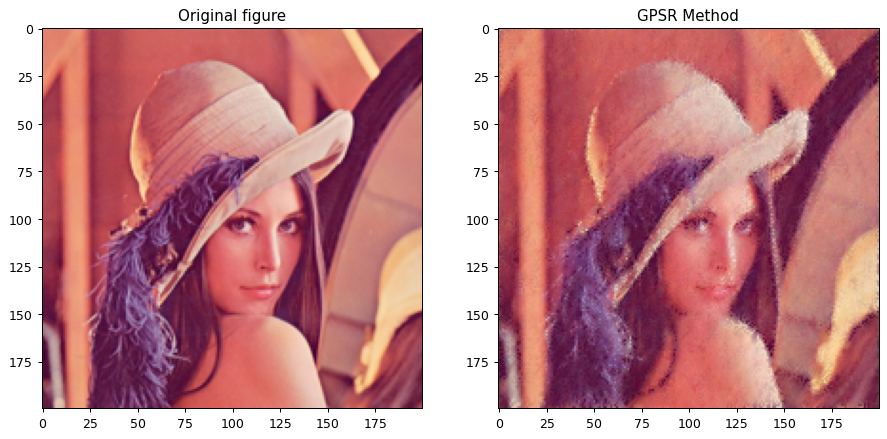

In [260]:
with HiddenPrints():
    x0, _ = GPSR_Basic(y=yy0, A=A, tau=0.05)
    x1, _ = GPSR_Basic(y=yy1, A=A, tau=0.05)
    x2, _ = GPSR_Basic(y=yy2, A=A, tau=0.05)

sig0 = spfft.idct(x0, norm='ortho', axis=0)
sig1 = spfft.idct(x1, norm='ortho', axis=0)
sig2 = spfft.idct(x2, norm='ortho', axis=0)
sig = np.zeros((np.size(lena_array[:,:,0],0), np.size(lena_array[:,:,0],1),3))
sig[:,:,0] = np.reshape(sig0, (np.size(lena_array[:,:,0],0), np.size(lena_array[:,:,0],1)))
sig[:,:,1] = np.reshape(sig1, (np.size(lena_array[:,:,1],0), np.size(lena_array[:,:,1],1)))
sig[:,:,2] = np.reshape(sig2, (np.size(lena_array[:,:,2],0), np.size(lena_array[:,:,2],1)))


fig = plt.figure(figsize=(12,8), dpi= 90)
plt.subplot(121)
plt.imshow(lena_array)
plt.title("Original figure")
plt.subplot(122)
plt.imshow(sig/255)
plt.title("GPSR Method")
print('The error is ', LA.norm(sig-lena_array,2)/LA.norm(lena_array))

C:\Users\Chenyang Cao\AppData\Local\Temp\ipykernel_4948\2560579764.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soltncoefi, _, _, _ = np.linalg.lstsq(X[:, nonzerosoltncoef], y)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'OMP Method')

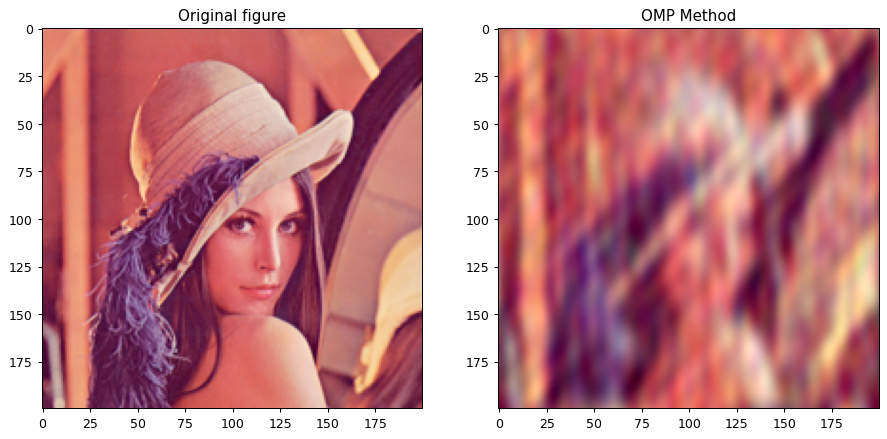

In [78]:
blockPrint()
x0, _, _, _, _ = omp(A, yy0,nonneg = False)
x1, _, _, _, _ = omp(A, yy1,nonneg = False)
x2, _, _, _, _ = omp(A, yy2,nonneg = False)


sig0 = spfft.idct(x0, norm='ortho', axis=0)
sig1 = spfft.idct(x1, norm='ortho', axis=0)
sig2 = spfft.idct(x2, norm='ortho', axis=0)
sig = np.zeros((np.size(lena_array[:,:,0],0), np.size(lena_array[:,:,0],1),3))
sig[:,:,0] = np.reshape(sig0, (np.size(lena_array[:,:,0],0), np.size(lena_array[:,:,0],1)))
sig[:,:,1] = np.reshape(sig1, (np.size(lena_array[:,:,1],0), np.size(lena_array[:,:,1],1)))
sig[:,:,2] = np.reshape(sig2, (np.size(lena_array[:,:,2],0), np.size(lena_array[:,:,2],1)))


fig = plt.figure(figsize=(12,8), dpi= 90)
plt.subplot(121)
plt.imshow(lena_array)
plt.title("Original figure")
plt.subplot(122)
plt.imshow(sig/255)
plt.title("OMP Method")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SpaRSA Method')

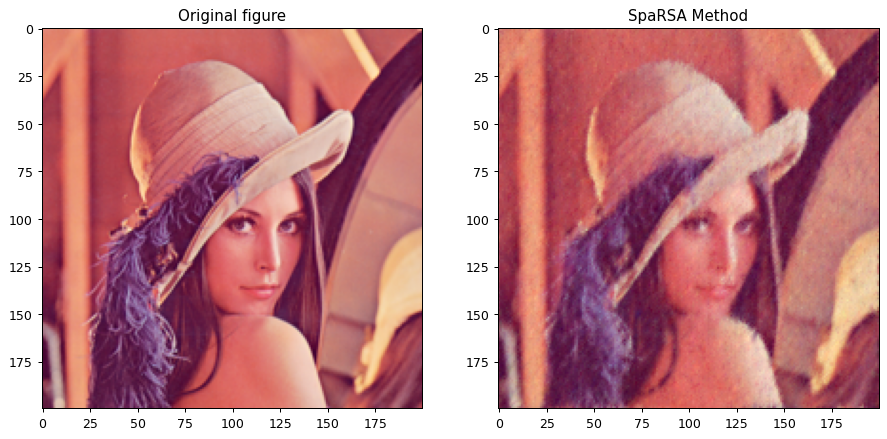

In [79]:
blockPrint()

x0, _ = spaRSA(A, yy0, tau = tau0)
x1, _ = spaRSA(A, yy1, tau = tau1)
x2, _ = spaRSA(A, yy2, tau = tau2)

sig0 = spfft.idct(x0, norm='ortho', axis=0)
sig1 = spfft.idct(x1, norm='ortho', axis=0)
sig2 = spfft.idct(x2, norm='ortho', axis=0)
sig = np.zeros((np.size(lena_array[:,:,0],0), np.size(lena_array[:,:,0],1),3))
sig[:,:,0] = np.reshape(sig0, (np.size(lena_array[:,:,0],0), np.size(lena_array[:,:,0],1)))
sig[:,:,1] = np.reshape(sig1, (np.size(lena_array[:,:,1],0), np.size(lena_array[:,:,1],1)))
sig[:,:,2] = np.reshape(sig2, (np.size(lena_array[:,:,2],0), np.size(lena_array[:,:,2],1)))


fig = plt.figure(figsize=(12,8), dpi= 90)
plt.subplot(121)
plt.imshow(lena_array)
plt.title("Original figure")
plt.subplot(122)
plt.imshow(sig/255)
plt.title("SpaRSA Method")

# 4. Sparse representation of classification

In [197]:
import scipy.io
from skimage.transform import resize
from matplotlib.image import imread

mat = scipy.io.loadmat(os.path.join('allFaces.mat'))
X = mat['faces']
nfaces = mat['nfaces'].reshape(-1)
n = mat['n']
n = int(n)
m = mat['m']
m = int(m)


In [198]:
## Build Training and Test sets
nTrain = 30
nTest = 20
nPeople = 20
Train = np.zeros((X.shape[0],nTrain*nPeople))
Test = np.zeros((X.shape[0],nTest*nPeople))

for k in range(nPeople):
    baseind = 0
    if k > 0:
        baseind = np.sum(nfaces[:k])
    inds = range(baseind,baseind+nfaces[k])
    Train[:,k*nTrain:(k+1)*nTrain] = X[:,inds[:nTrain]]
    Test[:,k*nTest:(k+1)*nTest] = X[:,inds[nTrain:(nTrain+nTest)]]



In [240]:
## Downsample Training Images (Build Theta)
M = Train.shape[1]

Theta = np.zeros((120,M))
for k in range(M):
    temp = np.reshape(np.copy(Train[:,k]),(m,n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Theta[:,k] = np.reshape(tempSmall,120)


## Renormalize Columns of Theta
normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:,k])
    Theta[:,k] = Theta[:,k]/normTheta[k]



In [262]:
##### Test for person 4, 8th image 3*20+7 = 67  #######
x1 = np.copy(Test[:,67]) # Clean image
temp = np.reshape(np.copy(x1),(m,n))
tempSmall = resize(temp, (10, 12), anti_aliasing=True)
y1 = np.reshape(tempSmall,120)
tau0 = 0.0005 * LA.norm(Theta.T @ y1, ord=np.inf) 
s1, _ = GPSR_Basic(y=y1, A=Theta, tau=tau0) # GPSR
s2, _, _, _, _ = omp(Theta, y1, nonneg = False) # OMP
s3, _ = spaRSA(Theta, y1, tau = tau0) # SpaRSA

C:\Users\Chenyang Cao\AppData\Local\Temp\ipykernel_4948\2560579764.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soltncoefi, _, _, _ = np.linalg.lstsq(X[:, nonzerosoltncoef], y)


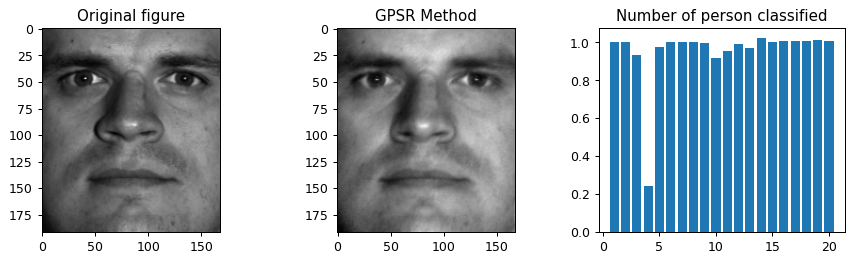

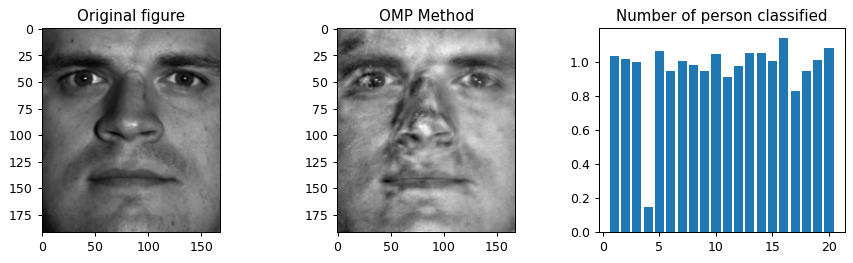

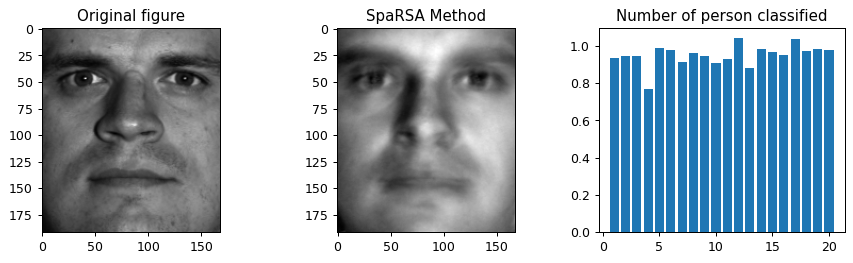

In [263]:
# GPSR
fig = plt.figure(figsize=(12,3), dpi= 90)
plt.subplot(131)
plt.imshow(temp.T, cmap='gray')
plt.title("Original figure")
plt.subplot(132)
plt.imshow(np.reshape(Train @ (s1/normTheta),(m,n)).T,cmap='gray')
plt.title("GPSR Method")

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s1[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.subplot(133)
plt.bar(range(1, nPeople+1),binErr)
plt.title('Number of person classified')
plt.show()

# OMP 
fig = plt.figure(figsize=(12,3), dpi= 90)
plt.subplot(131)
plt.imshow(temp.T, cmap='gray')
plt.title("Original figure")
plt.subplot(132)
plt.imshow(np.reshape(Train @ (s2/normTheta),(m,n)).T,cmap='gray')
plt.title("OMP Method")

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s2[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.subplot(133)
plt.bar(range(1, nPeople+1),binErr)
plt.title('Number of person classified')
plt.show()

# SpaRSA

fig = plt.figure(figsize=(12,3), dpi= 90)
plt.subplot(131)
plt.imshow(temp.T, cmap='gray')
plt.title("Original figure")
plt.subplot(132)
plt.imshow(np.reshape(Train @ (s3/normTheta),(m,n)).T,cmap='gray')
plt.title("SpaRSA Method")

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s3[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.subplot(133)
plt.bar(range(1, nPeople+1),binErr)
plt.title('Number of person classified')
plt.show()



In [264]:
##### Test for person 15, 8th image 14*20+7 = 287  #######

x1 = np.copy(Test[:,287]) # Clean image
temp = np.reshape(np.copy(x1),(m,n))
tempSmall = resize(temp, (10, 12), anti_aliasing=True)
y1 = np.reshape(tempSmall,120)
tau0 = 0.0005 * LA.norm(Theta.T @ y1, ord=np.inf) 
s1, _ = GPSR_Basic(y=y1, A=Theta, tau=tau0) # GPSR
s2, _, _, _, _ = omp(Theta, y1, nonneg = False) # OMP
s3, _ = spaRSA(Theta, y1, tau = tau0) # SpaRSA


C:\Users\Chenyang Cao\AppData\Local\Temp\ipykernel_4948\2560579764.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soltncoefi, _, _, _ = np.linalg.lstsq(X[:, nonzerosoltncoef], y)


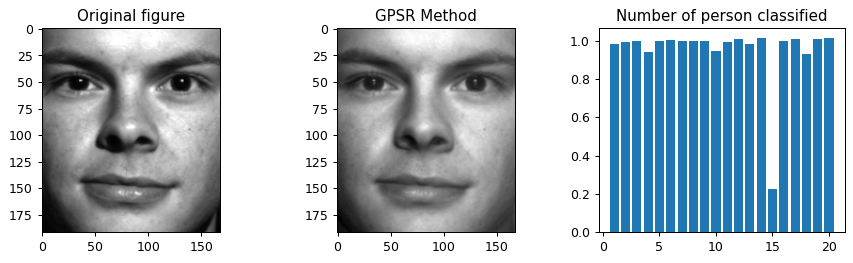

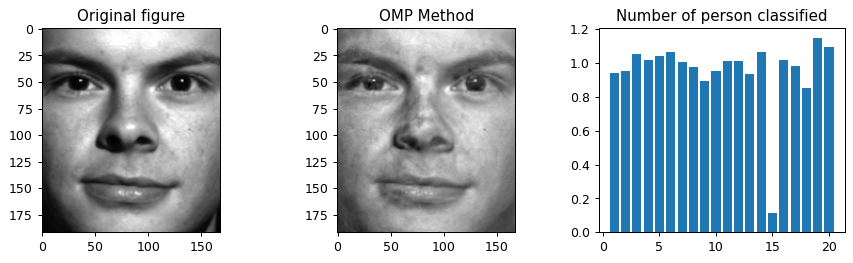

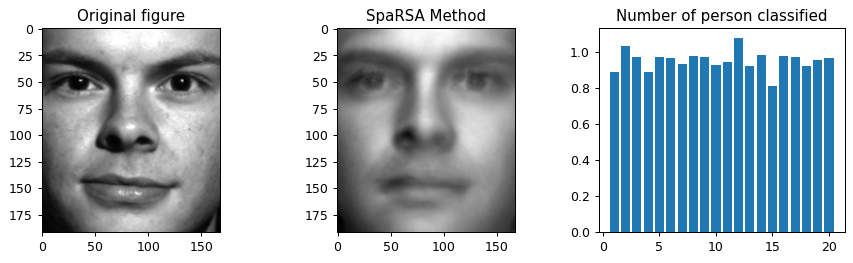

In [265]:
# GPSR
fig = plt.figure(figsize=(12,3), dpi= 90)
plt.subplot(131)
plt.imshow(temp.T, cmap='gray')
plt.title("Original figure")
plt.subplot(132)
plt.imshow(np.reshape(Train @ (s1/normTheta),(m,n)).T,cmap='gray')
plt.title("GPSR Method")

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s1[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.subplot(133)
plt.bar(range(1, nPeople+1),binErr)
plt.title('Number of person classified')
plt.show()

# OMP 
fig = plt.figure(figsize=(12,3), dpi= 90)
plt.subplot(131)
plt.imshow(temp.T, cmap='gray')
plt.title("Original figure")
plt.subplot(132)
plt.imshow(np.reshape(Train @ (s2/normTheta),(m,n)).T,cmap='gray')
plt.title("OMP Method")

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s2[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.subplot(133)
plt.bar(range(1, nPeople+1),binErr)
plt.title('Number of person classified')
plt.show()

# SpaRSA

fig = plt.figure(figsize=(12,3), dpi= 90)
plt.subplot(131)
plt.imshow(temp.T, cmap='gray')
plt.title("Original figure")
plt.subplot(132)
plt.imshow(np.reshape(Train @ (s3/normTheta),(m,n)).T,cmap='gray')
plt.title("SpaRSA Method")

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s3[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.subplot(133)
plt.bar(range(1, nPeople+1),binErr)
plt.title('Number of person classified')
plt.show()

